In [74]:
import tensorflow as tf
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
import csv
import urllib.request
from scipy.special import softmax
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [75]:
def preprocess(text):
    new_text = []
 
 
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [76]:
task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [77]:
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

In [78]:
model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [79]:
map={0:'negative',1:'neutral',2:'positive'}
data=pd.read_csv('Data/CompanyTweets.csv')
df=data[['body']]

In [80]:
n=10000
step=int(n*0.1)
blocks=int(n/step)
bar=[' ']*(blocks+2)
bar[0]='['
bar[len(bar)-1]=']'
random_rows = df.sample(n=n)
sentiment=[]
counter=1    
index=1
for unprocessed in random_rows['body']:
    text=preprocess(unprocessed)
    encoded_input = tokenizer(text, return_tensors='tf')
    output = model(encoded_input)
    scores = output[0][0].numpy()
    scores = softmax(scores)
    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    if ranking[0]==1:
        sentiment.append(map[ranking[1]])
    else:
        sentiment.append(map[ranking[0]])
    if counter%step==0:
        clear_output()
        bar[index]='='
        for chunck in bar:
            print(chunck, end="")
        print('\n')
        index+=1
    counter+=1
    
random_rows['sentiment']=sentiment

[==========]



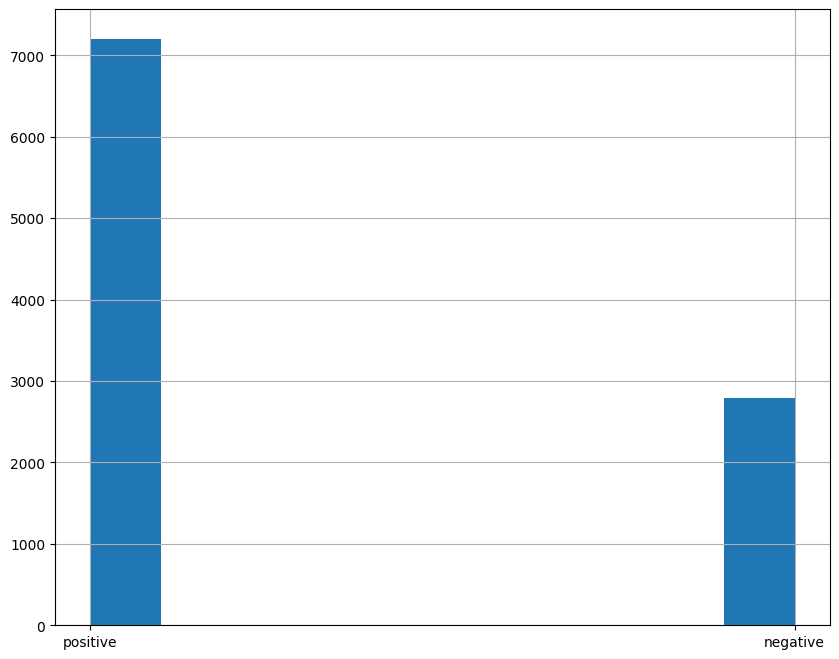

In [81]:
random_rows['sentiment'].hist(figsize=(10,8))
plt.show()

In [82]:
random_rows.to_csv('Data/SentimentSample.csv',index=True)